# Multiple Variable Linear Regression

In this notebook, we implement multi-variable linear regression from stratch. The goal is to predict a student's performance based on factors:
* Hours Studied
* Previous Scores
* Extracurricular Activities
* Sleep Hours
* Sample Question Papers Practiced

## 1. Import Required Libraries

Import the requied libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Load and Preprocess the Data

Load the dataset and convert the relevant columns to NumPy arrays.

In [ ]:
# Load the dataset
data = pd.read_csv('Student_Performance.csv')

# Map Yes to 1 and No to 0
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [3]:
# Seprate the features from target
x_data = data.drop('Performance Index', axis=1)
y_data = data['Performance Index']

x_features = x_data.columns.to_list()
print(x_features)

['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']


In [4]:
# Convert to numpy array
x_train = x_data.values #features
y_train = y_data.values # target values

number_of_features = x_train.shape[1]
print(f"Number of features: {number_of_features}")

length = len(y_train)   # length of the numpy array
print(f"Length of the data: {length}")

Shape of features array: 5
Length of the data: 10000


## 3. Initial Setup

We initialize weights and bias with arbitrary values.
* Weight(w): Determines the slope of the regression line.
* Bias(b): Determines the intercept of the regression line.

In [5]:
# Set initial values for the weights and bias
w_initial = np.array([30, 30, 5, 15, 20], dtype=float)
b_initial = 10.0

## 4. Define Key Functions

### a. Z-Score Normalization
Center the data around 0 and make a Gaussian Distribution using the formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{1}$$ 

In [6]:
# Function to perform z-score normalization
def z_score_normalization(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mean) / std

### b. Predicted Value (Hypothesis)
The hypothesis for linear regression is given by:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector dot product

In [7]:
# Function to compute predictions
def compute_f_wb(w, x, b):
    f_wb = np.dot(x, w) + b
    f_wb = np.clip(f_wb, 0, 100)  # Bound predictions between 0 and 100
    return f_wb

### c. Cost Function

The cost function measures how far our predictions are from the actual values. For linear regression, it is given by the Mean Squared Error (MSE):
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 

In [8]:
# Function to calculate the cost
def compute_cost(f_wb, y, length):
    return np.mean(np.square(f_wb - y)) / 2

### d. Feature Engineering

Use $\mathbf{x}^{2}$ instead of $\mathbf{x}$ depending on the data

In [9]:
# Function for polynomial feature engineering
def feature_engineering(x, degree=2):
    return x ** degree

### e. Compute Gradients

Gradients for weight and bias are derived from the cost function:
$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{4}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{5}
\end{align}
$$

In [10]:
# Functions to compute gradients
def compute_dj_dw(x, y, f_wb, length):
    return np.dot((f_wb - y), x) / length

def compute_dj_db(f_wb, y, length):
    return np.sum(f_wb - y) / length

## 5. Visualization of Data

We can plot the data to visualize the initial predictions and actual data points.

In [11]:
# Function to draw the graph
def draw_function(x, y, f_wb, features):
    for i, feature in enumerate(features):
        plt.scatter(x[:, i], y, marker='o', c='r', label='Actual Data')
        sorted_indices = np.argsort(x[:, i])
        plt.plot(x[sorted_indices, i], f_wb[sorted_indices], c='b', label='Predicted Data')
        plt.title(f"{feature} vs Performance Index")
        plt.xlabel(feature)
        plt.ylabel("Performance Index")
        if i == 0:
            plt.legend()
        plt.grid()
        plt.show()

## 6. Gradient Descent with Multiple Variables

Gradient Descent updates weights and bias iteratively:
$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{6}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where $\alpha$ is the learning rate.

In [12]:
# Function to perform gradient descent
def gradient_descent(x, y, w, b, length, alpha, max_iterations=10000, tolerance=1e-6):
    prev_cost = float('inf')
    for i in range(max_iterations):
        f_wb = compute_f_wb(w, x, b)
        cost = compute_cost(f_wb, y, length)
        
        if abs(prev_cost - cost) < tolerance:
            break
        prev_cost = cost

        dj_dw = compute_dj_dw(x, y, f_wb, length)
        dj_db = compute_dj_db(f_wb, y, length)
        w -= alpha * dj_dw
        b -= alpha * dj_db
    
    return w, b, compute_f_wb(w, x, b)

## 7. Compute the Initial Condition

We calculate the initial cost and plot it to get a better understanding of the data and perform feature engineering if required.

Initial cost: 49751556.78302493


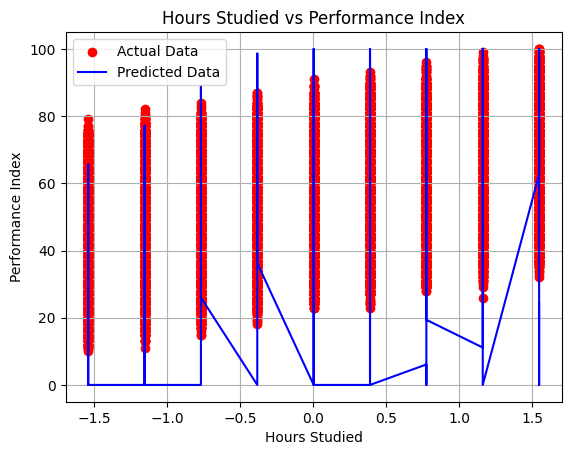

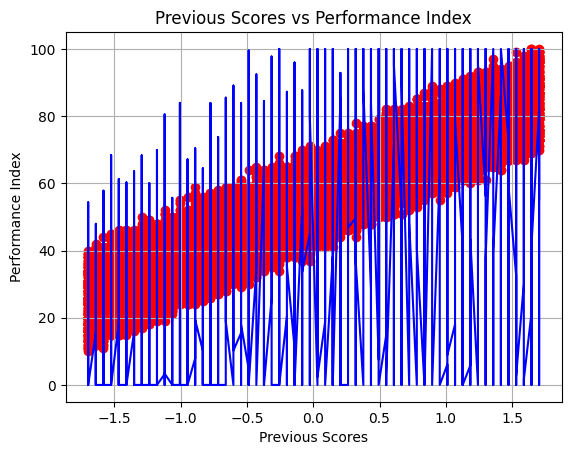

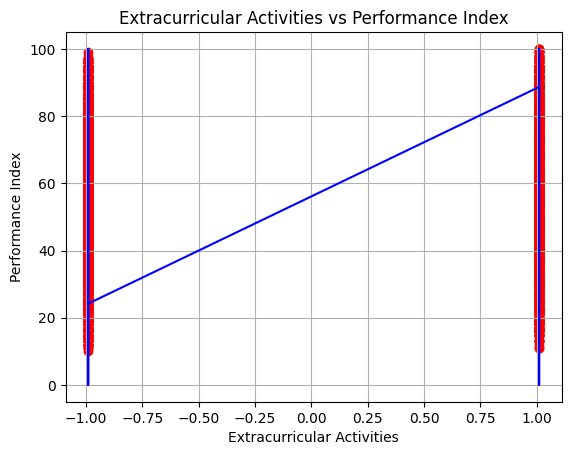

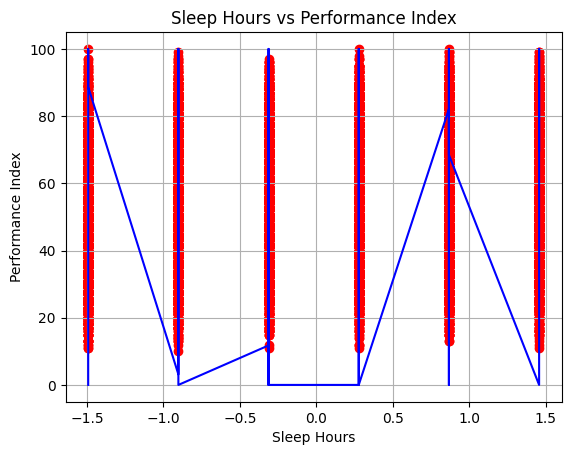

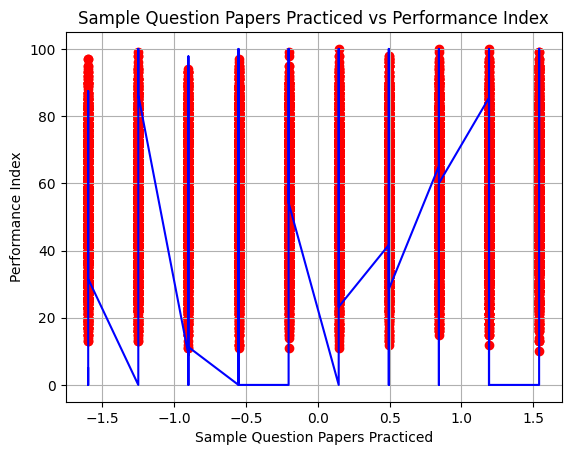

In [13]:
# Preprocessing
x_norm = z_score_normalization(x_train)

# Initial predictions and cost
f_wb_initial = compute_f_wb(w_initial, x_norm, b_initial)
cost_initial = compute_cost(length, f_wb_initial, y_train)
print(f"Initial cost: {cost_initial}")

# Visualize initial predictions
draw_function(x_norm, y_train, f_wb_initial, x_features)

# Feature engineering
x_poly = feature_engineering(x_train)
x_norm_poly = z_score_normalization(x_poly)

## 9. Coefficient of Determination (R²)

R² evaluates the goodness of fit for the model:

Where:
$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}} \tag{7}
$$

In [14]:
# Function to calculate the goodness of fit (R^2)
def compute_r2(y, f_wb):
    y_mean = np.mean(y)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_residual = np.sum((y - f_wb) ** 2)
    r = 1 - (ss_residual / ss_total)
    return r

## 10. Perform the Calculations

Perform Gradient Descent and Evaluate the model and draw a graph to check the fit of the data.

Final cost: 49449505.26219845
Optimized weights: [ 7.21599944 17.58216535  0.33050796  0.77891759  0.51858102]
Optimized bias: 55.22712227200547
R^2 Score: 0.9712275011620859


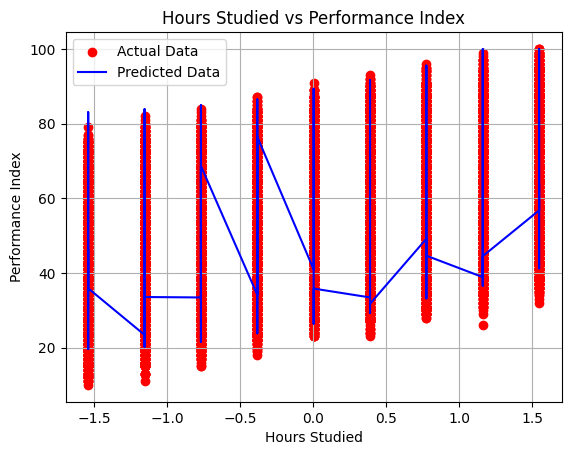

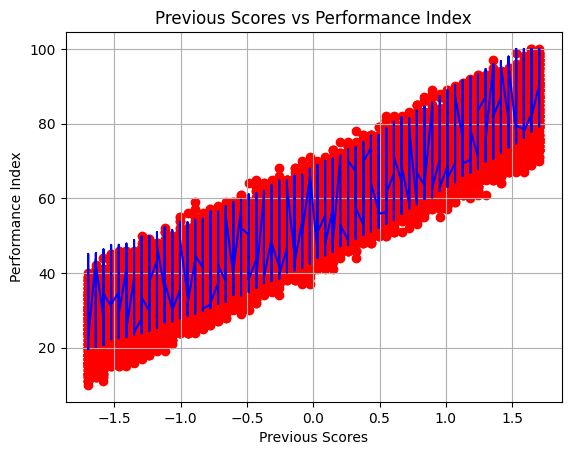

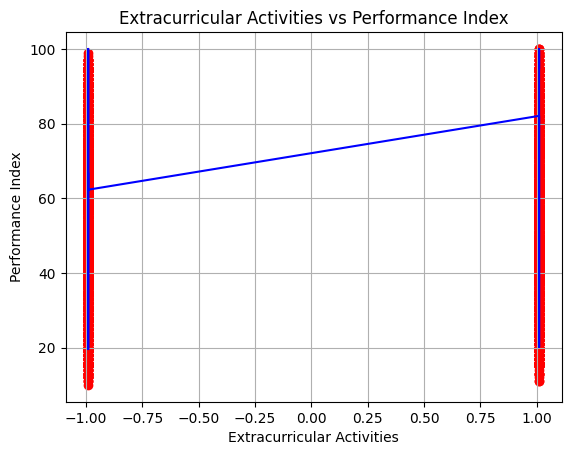

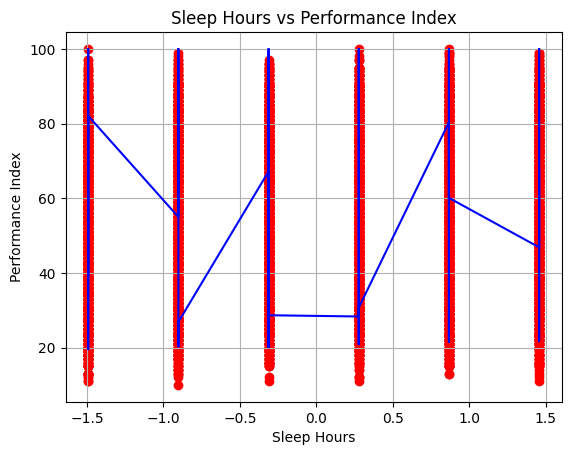

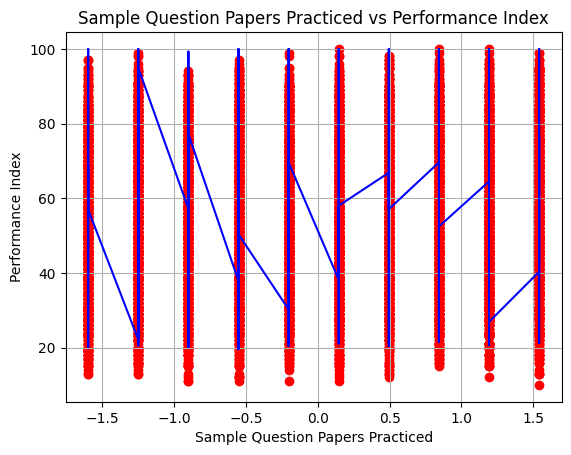

In [17]:
# Gradient descent
alpha = 0.01  # Learning rate
w, b, f_wb = gradient_descent(x_norm_poly, y_train, w_initial, b_initial, length, alpha)

# Final cost and predictions
final_cost = compute_cost(length, f_wb, y_train)
print(f"Final cost: {final_cost}")
print(f"Optimized weights: {w}")
print(f"Optimized bias: {b}")

# Compute the value R^2
r = compute_r2(y_train, f_wb)
print(f"R^2 Score: {r}")

# Visualize final predictions
draw_function(x_norm, y_train, f_wb, x_features)

## 11. Make Predictions

Now we are ready to make predictions from the linear model.

In [18]:
# Predict the values
x_predict = np.array([6, 71, 1, 8, 2])
x_norm_predict = z_score_normalization(x_predict)
predicted_performance_index = np.dot(w, x_norm_predict) + b
print(f"Predicted Performance Index: {predicted_performance_index}")

Predicted Performance Index: 86.32533843153955
